In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset, DataLoader

PATH = "kaggle_3m"
IMAGE_SIZE = (256, 256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

paths = []

for dirname in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, dirname)):
        
        for filename in os.listdir(os.path.join(PATH, dirname)):
            if filename.endswith('.tif'):
                paths.append(PATH+'/'+dirname+'/'+filename)


def data_frame(data):
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    pixels = lambda x: Image.open(x)
    largest_pixel = lambda y: np.max(pixels(y))
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    data_df = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})
    
    train_index, val_index = train_test_split(data_df.index.values.tolist(), test_size=0.19, random_state=42)
    val_index, test_index = train_test_split(val_index, test_size=0.12, random_state=42)
    
    # Making train, test, and validation dataframes
    train_df, val_df, test_df = data_df.iloc[train_index], data_df.iloc[val_index], data_df.iloc[test_index]
    
    return train_df, val_df, test_df
    
# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

print(train_df.head())

def tensor_from_path(path):
    arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    arr = cv2.resize(arr, IMAGE_SIZE)
    arr = arr / 255
    if len(arr.shape) == 3:
        tensor = torch.tensor(arr).permute(2,0,1)
    elif len(arr.shape) == 2:
        tensor = torch.tensor(arr).unsqueeze(0)
    else:
        raise ValueError(f"Expected data shape to be (..., ..., 3) or (..., ...) , but got {arr.shape}")
    return tensor

class data(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df        
        self.images = self.df.loc[:,'Image'].values
        self.masks = self.df.loc[:,'Mask'].values
        self.diagnosis = self.df.loc[:,'Diagnosis'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        im_path = self.images[idx]
        msk_path= self.masks[idx]
        diagnosis = self.diagnosis[idx]
        self.im_tensor = tensor_from_path(im_path)
        self.msk_tensor= tensor_from_path(msk_path)
        return self.im_tensor.to(device), self.msk_tensor.to(device),diagnosis

train_ds = data(train_df)
test_ds = data(test_df)

train_dl = DataLoader(train_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

cpu
3182 657 90
                            ID  \
812   TCGA_DU_7302_19911203_33   
1550  TCGA_HT_7602_19951103_17   
2228  TCGA_DU_A5TR_19970726_31   
1108  TCGA_DU_5872_19950223_26   
3728  TCGA_FG_7643_20021104_17   

                                                  Image  \
812   kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_1...   
1550  kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_1...   
2228  kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1...   
1108  kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...   
3728  kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_2...   

                                                   Mask  Diagnosis  
812   kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_1...          0  
1550  kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_1...          0  
2228  kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1...          0  
1108  kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...          0  
3728  kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_2...          0  


In [2]:
import torch
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        '''
        starts at torch.Size([4, 3, 256, 256])
        torch.Size([4, 6, 252, 252])
        torch.Size([4, 6, 126, 126])
        torch.Size([4, 16, 122, 122])
        torch.Size([4, 16, 61, 61])`
        then flattens to NN
        '''
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net = Net().to(device)

In [3]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

dataloader = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)

for epoch in range(7):
    correct = 0
    total = 0
    current_predicted = 0
    current_total = 0
    for i, data in enumerate(dataloader, 0):

        inputs, _,labels = data
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = net(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predicted = torch.round(outputs.data) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        current_total += labels.size(0)
        current_predicted += (predicted == labels).sum().item()
        if i % 100 == 0:
            print('epoch',epoch)
            print('Current accaracy: %d %%' % (100 * current_predicted / current_total))
            print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
            current_predicted = 0
            current_total = 0


print('Finished Training')


epoch 0
Current accaracy: 0 %
Accuracy of the network on the train images: 0 %
epoch 0
Current accaracy: 65 %
Accuracy of the network on the train images: 65 %
epoch 0
Current accaracy: 69 %
Accuracy of the network on the train images: 67 %
epoch 0
Current accaracy: 73 %
Accuracy of the network on the train images: 69 %
epoch 0
Current accaracy: 77 %
Accuracy of the network on the train images: 71 %
epoch 0
Current accaracy: 78 %
Accuracy of the network on the train images: 72 %
epoch 0
Current accaracy: 82 %
Accuracy of the network on the train images: 74 %
epoch 0
Current accaracy: 76 %
Accuracy of the network on the train images: 74 %
epoch 1
Current accaracy: 100 %
Accuracy of the network on the train images: 100 %
epoch 1
Current accaracy: 79 %
Accuracy of the network on the train images: 79 %
epoch 1
Current accaracy: 82 %
Accuracy of the network on the train images: 81 %
epoch 1
Current accaracy: 79 %
Accuracy of the network on the train images: 80 %
epoch 1
Current accaracy: 80

In [4]:
net.eval()
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=4, shuffle=True)

from sklearn.metrics import precision_score, recall_score

correct = 0
total = 0
all_predicted = []
all_labels = []

for data in test_dataloader:
    images,_, labels = data
    images = images.float().to(device)
    labels = labels.float().to(device)
    outputs = net(images).squeeze()
    predicted = torch.round(outputs.data) #to add more precision
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    all_predicted.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, and recall
accuracy = 100 * correct / total
precision = precision_score(all_labels, all_predicted)
recall = recall_score(all_labels, all_predicted)

# Print the results
print('Accuracy of the network on the test images: %d %%' % accuracy)
print('Precision of the network on the test images: %f' % precision)
print('Recall of the network on the test images: %f' % recall)






Accuracy of the network on the test images: 85 %
Precision of the network on the test images: 0.880000
Recall of the network on the test images: 0.687500


In [5]:
%pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


For grad cam explaination 

https://github.com/jacobgil/pytorch-grad-cam

0.03380250930786133


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


0.4088904857635498
0.0233762264251709


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


0.3919658660888672
0.0245363712310791


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


0.38495755195617676
0.02420520782470703


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


0.39362144470214844


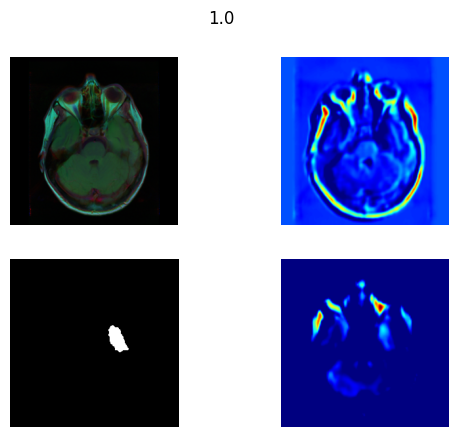

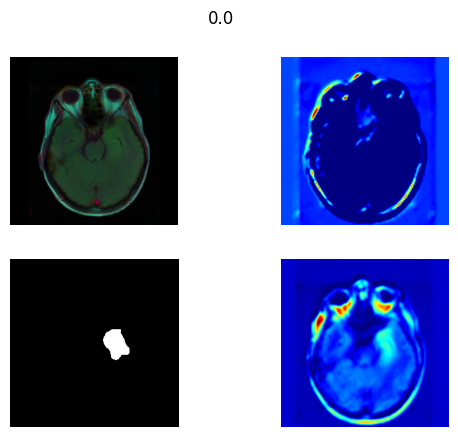

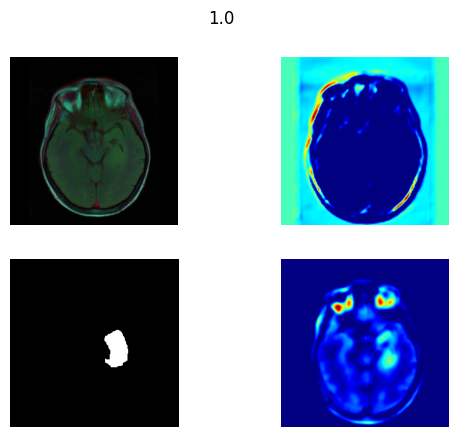

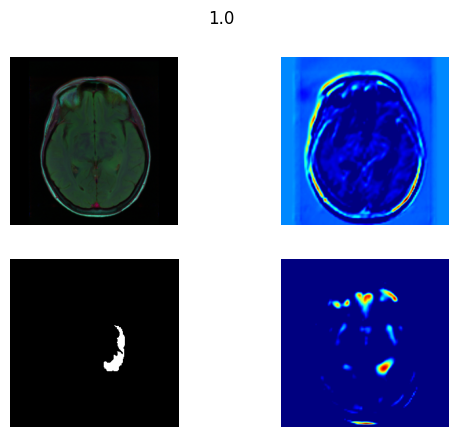

In [6]:
from pytorch_grad_cam import HiResCAM, EigenCAM,AblationCAM,XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import time

def visualize_prediction(path):
    target_layers = [net.conv2]
    input_tensor = tensor_from_path(path).float().to(device)
    input_tensor = input_tensor.unsqueeze(0)

    rgb_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    rgb_img = cv2.resize(rgb_img, IMAGE_SIZE)
    rgb_img = np.array(rgb_img,dtype=np.float32)
    rgb_img /= 256

    fig,ax=plt.subplots(nrows=2,ncols=2)

    fig.suptitle(torch.round(net(input_tensor).squeeze()).cpu().detach().numpy())

    ax[0][0].axis('off')   
    ax[0][0].imshow(rgb_img)


    mask_img = cv2.imread(path.replace('.tif','_mask.tif'), cv2.IMREAD_UNCHANGED)
    mask_img = cv2.resize(mask_img, IMAGE_SIZE)

    ax[1][0].axis('off')   
    ax[1][0].imshow(mask_img,cmap='gray')

    i = 2
    methods = [XGradCAM,AblationCAM]

    for method in methods:
        start = time.time()
        cam = method(model=net, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=input_tensor)
        grayscale_cam = grayscale_cam[0, :]
        end = time.time()
        print(end - start)

        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True,image_weight=0)

        ax[i%2][i//2].axis('off')
        ax[i%2][i//2].imshow(visualization)
        i+=1
        plt.plot()

visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9.tif')
visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif')
visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11.tif')

In a wierd fashion, even if the classification is wrong, we still get a good heatmap of abnormalities

0.025074481964111328


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

0.3897969722747803


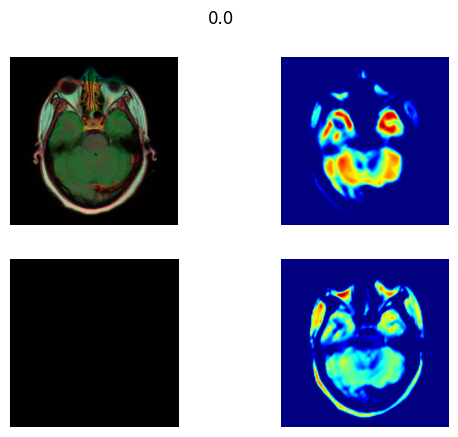

In [7]:
visualize_prediction('kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_11.tif')
#this case is no cancer


0.03618574142456055


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


0.5145559310913086
0.046891212463378906


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


0.672318696975708
0.0339663028717041


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


0.6111569404602051
0.04107546806335449


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


0.5956337451934814
0.03466010093688965


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


0.6630129814147949
0.05276203155517578


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


0.6065847873687744
0.04102444648742676


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


0.5424313545227051
0.026876211166381836


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


0.4782226085662842
0.02579021453857422


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


0.47228193283081055
0.02539348602294922


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.4465470314025879
0.02538013458251953


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.4511833190917969
0.026648283004760742


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


0.4399898052215576
0.02542853355407715


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


0.44333696365356445
0.026400089263916016


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.45157408714294434
0.02591395378112793


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


0.4404609203338623
0.02655649185180664


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.45162129402160645
0.02451038360595703


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


0.5723004341125488
0.027837276458740234


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


0.47540879249572754
0.035185813903808594


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.47579216957092285
0.025991439819335938


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
C:\Users\roee hilel\AppData\Local\Temp\ipykernel_14680\2484463701.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(nrows=2,ncols=2)


0.4433121681213379
0.022713422775268555


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


0.4376347064971924
0.02644515037536621


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


0.46109628677368164
0.025454282760620117


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


0.48331475257873535
0.02522587776184082


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.4539918899536133
0.02882552146911621


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


0.47260403633117676
0.026926755905151367


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


0.4697575569152832
0.027302980422973633


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.45001959800720215
0.02359485626220703


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


0.43815159797668457
0.025562524795532227


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.45302295684814453
0.023746967315673828


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


0.4369044303894043
0.024384498596191406


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.45777297019958496


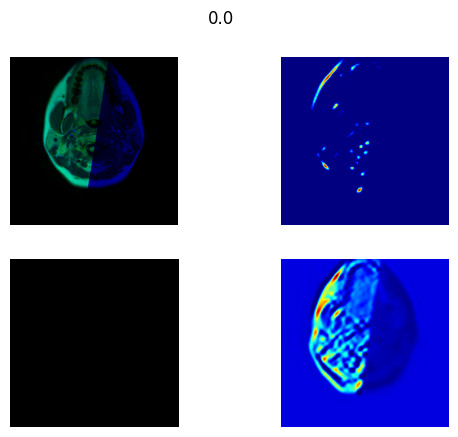

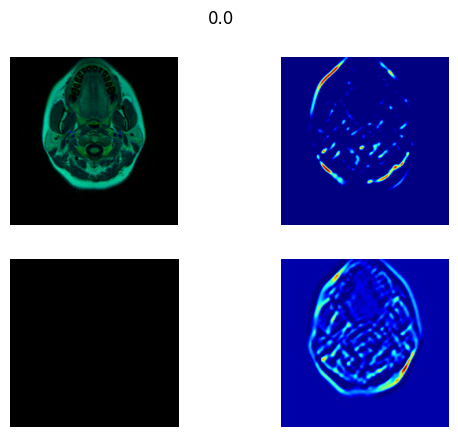

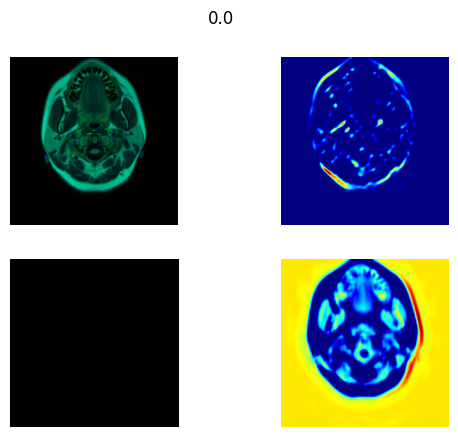

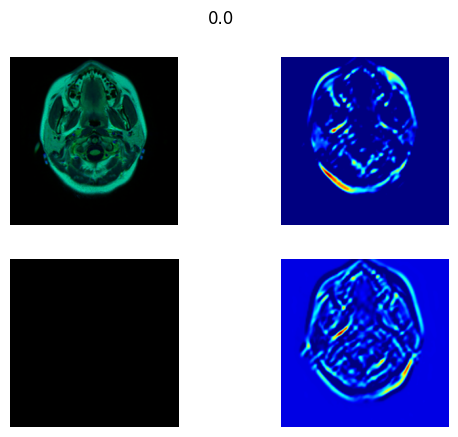

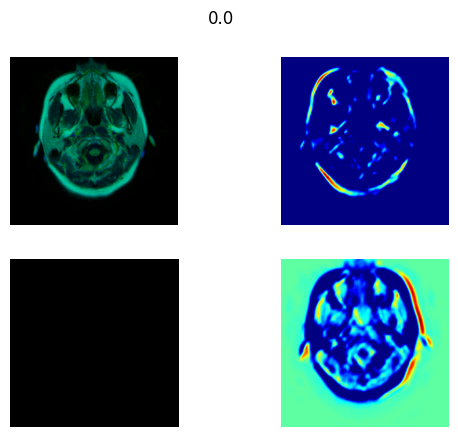

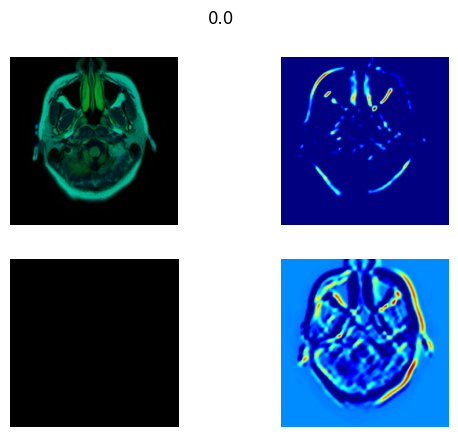

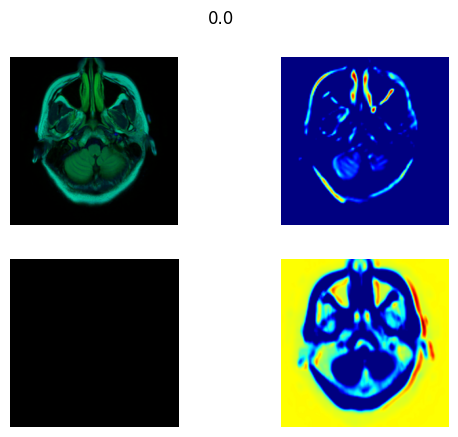

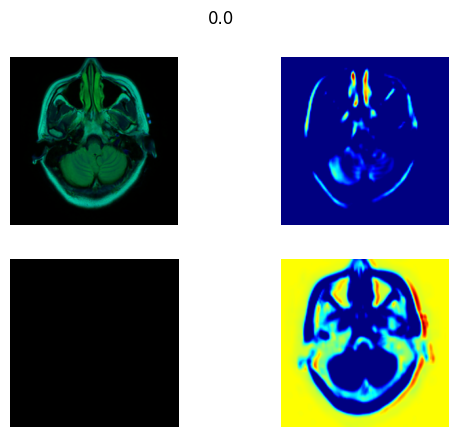

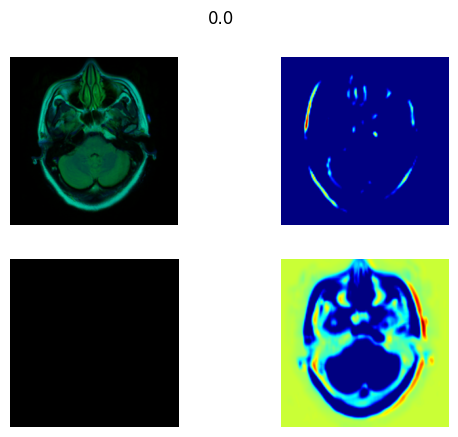

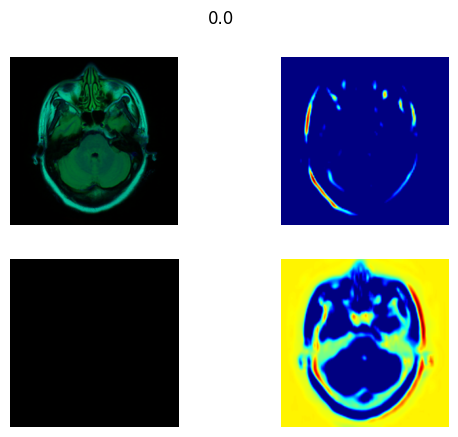

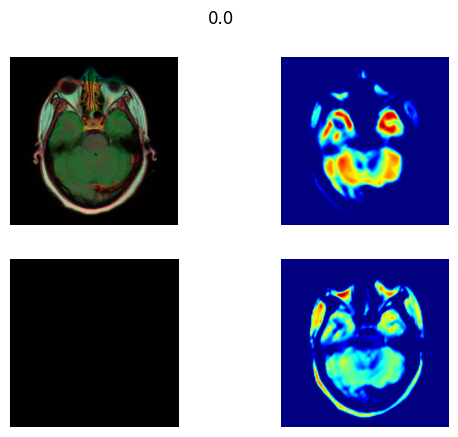

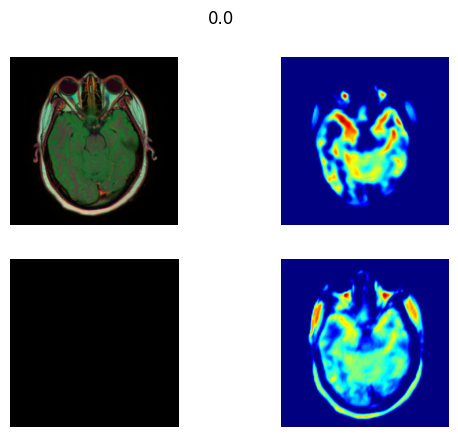

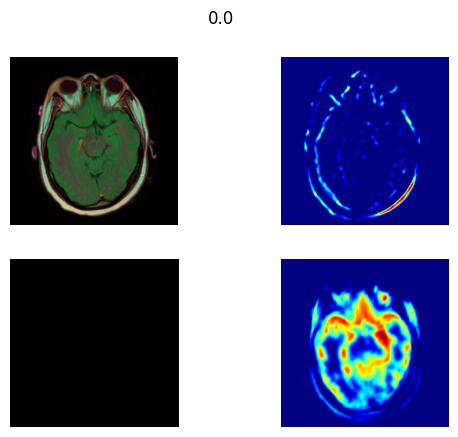

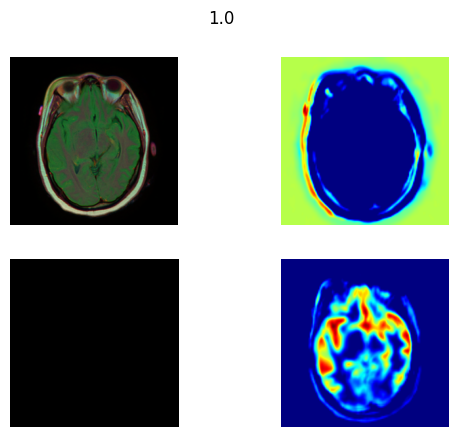

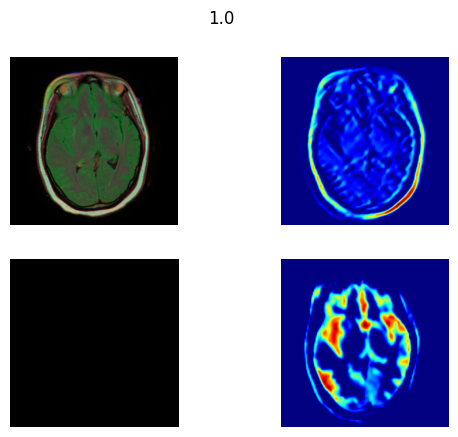

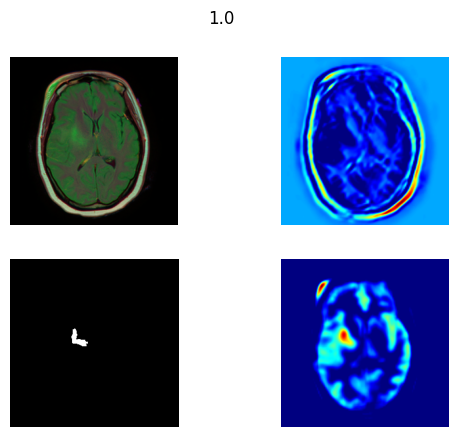

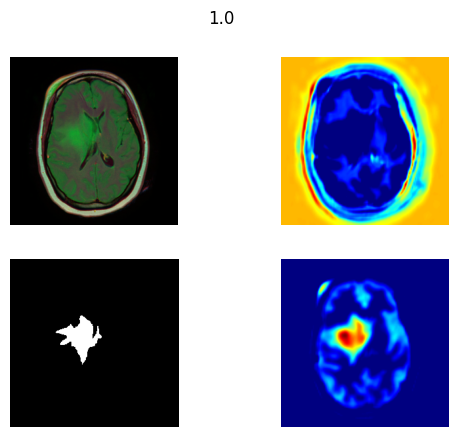

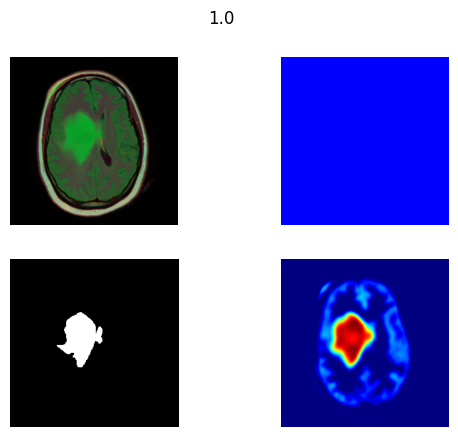

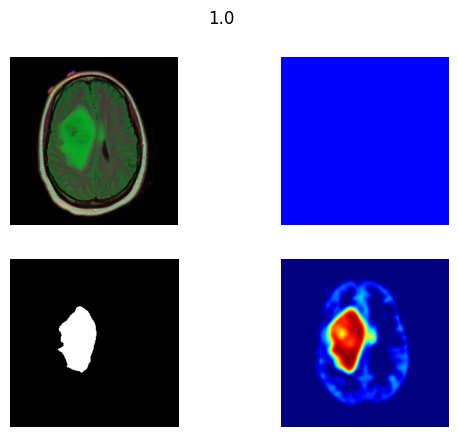

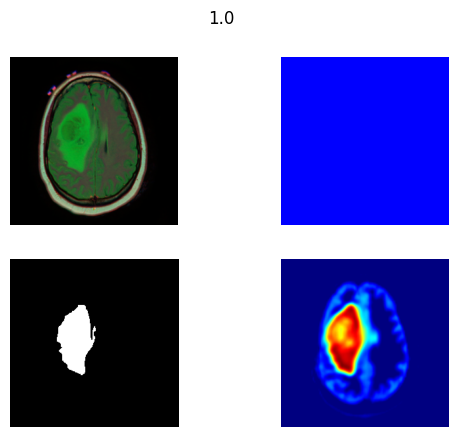

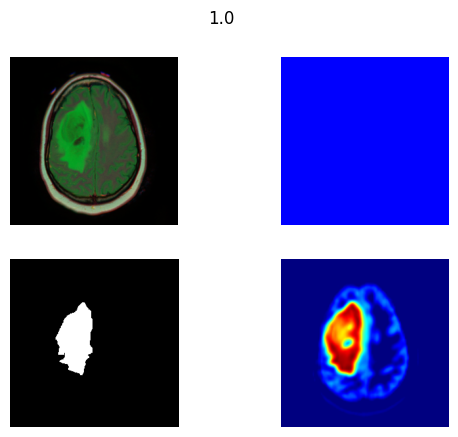

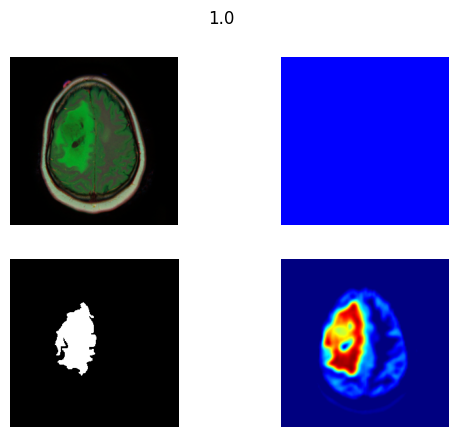

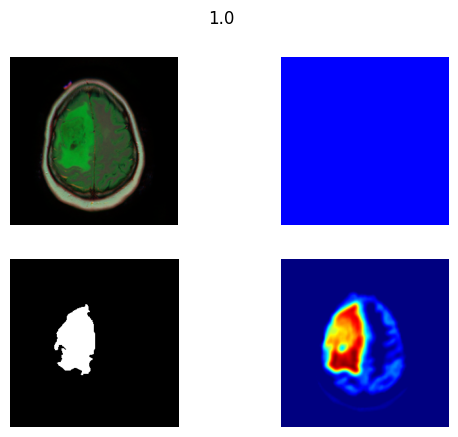

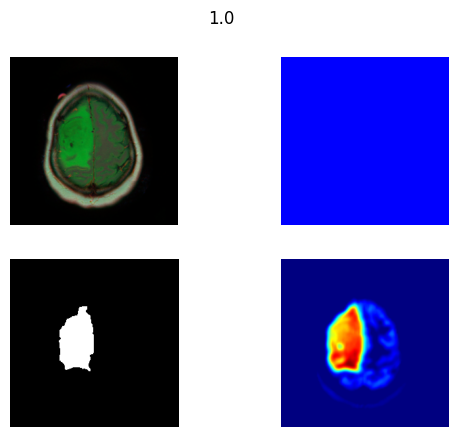

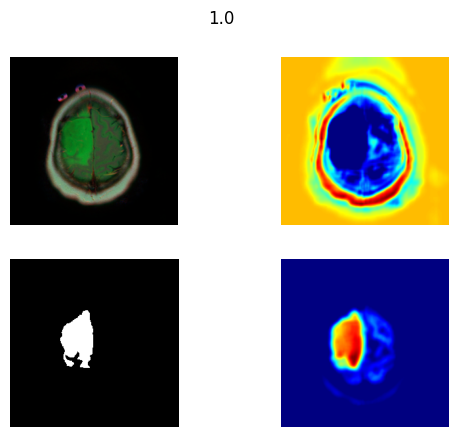

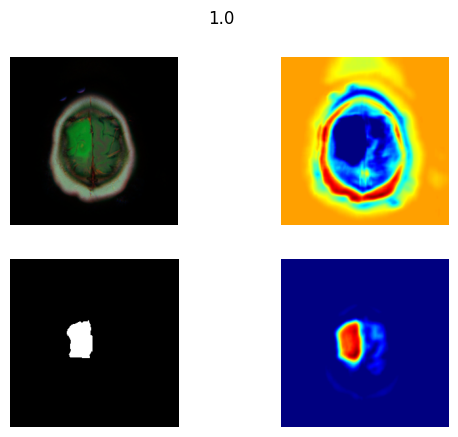

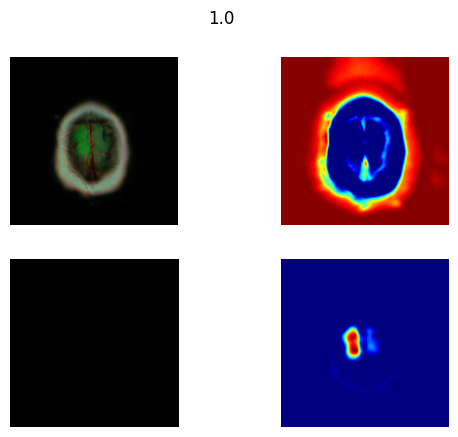

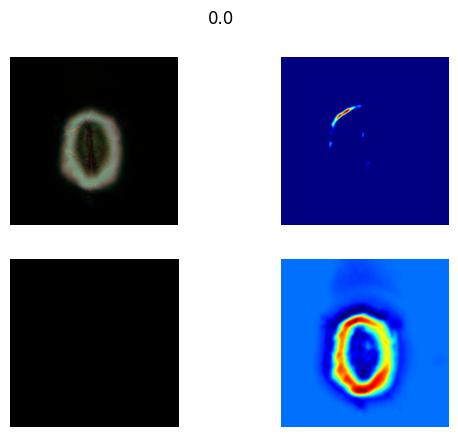

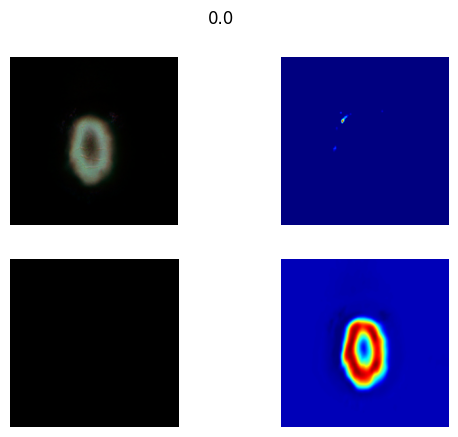

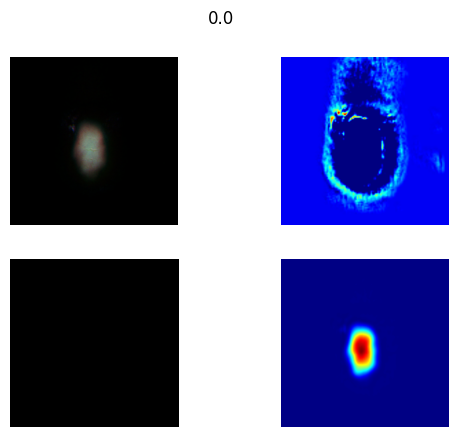

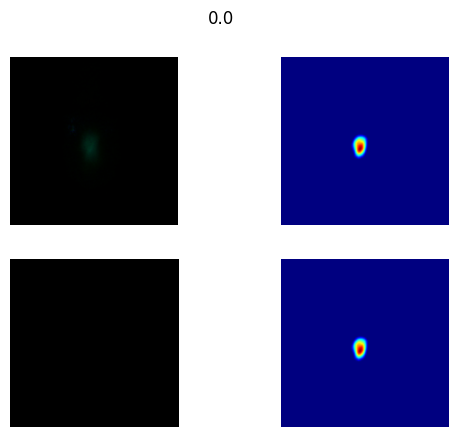

In [8]:
for i in range(1,32):
    visualize_prediction(f'kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_{i}.tif')

0.027513742446899414


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


0.38484692573547363
0.022537946701049805


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


0.38121938705444336
0.023530960083007812


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


0.3829672336578369
0.02441120147705078


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


0.3926064968109131
0.023955821990966797


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


0.3891613483428955
0.02442622184753418


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


0.3860182762145996
0.024489402770996094


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


0.38007497787475586
0.02656102180480957


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


0.3849756717681885
0.02266550064086914


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


0.40962791442871094
0.024337291717529297


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.4580109119415283
0.025031089782714844


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.44542479515075684
0.0253450870513916


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.4554579257965088
0.024669170379638672


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.45078325271606445
0.028041601181030273


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


0.4070429801940918
0.02355790138244629


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.4516170024871826
0.02459716796875


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


0.4452214241027832
0.03171110153198242


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


0.46317553520202637
0.027790546417236328


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


0.461885929107666
0.02631378173828125


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.45281291007995605
0.02441263198852539


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
C:\Users\roee hilel\AppData\Local\Temp\ipykernel_14680\2484463701.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(nrows=2,ncols=2)


0.4811863899230957
0.024363279342651367


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


0.4639613628387451
0.030072689056396484


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


0.4659883975982666
0.03258967399597168


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


0.4979856014251709
0.024437427520751953


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


0.4960460662841797
0.025394201278686523


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.45960545539855957


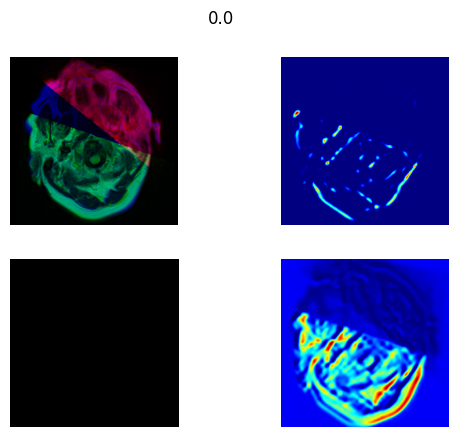

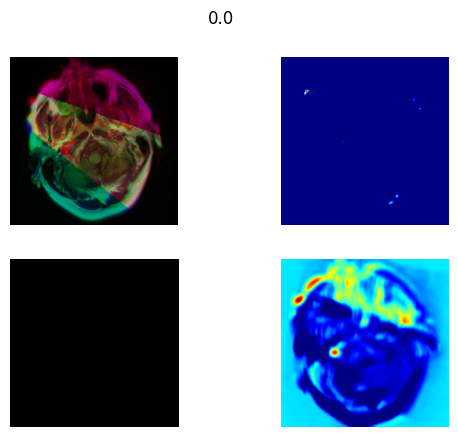

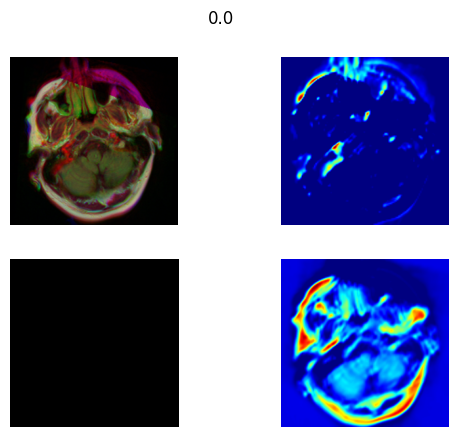

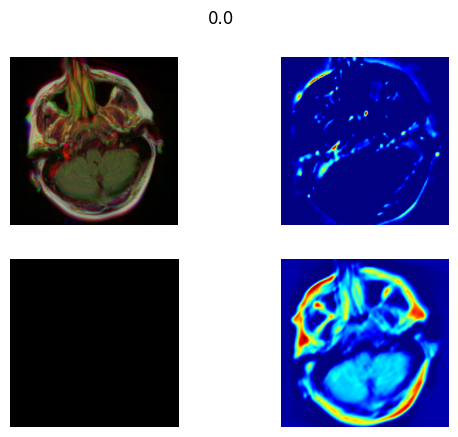

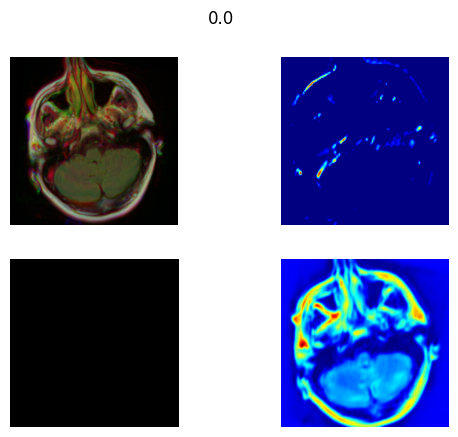

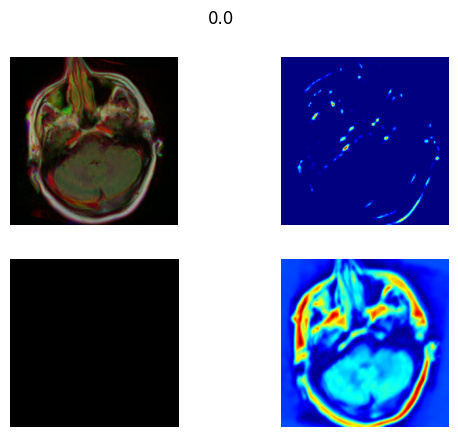

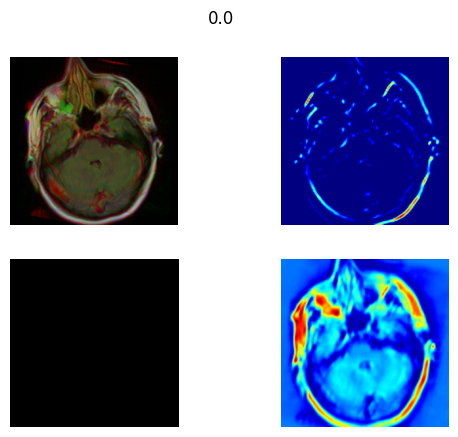

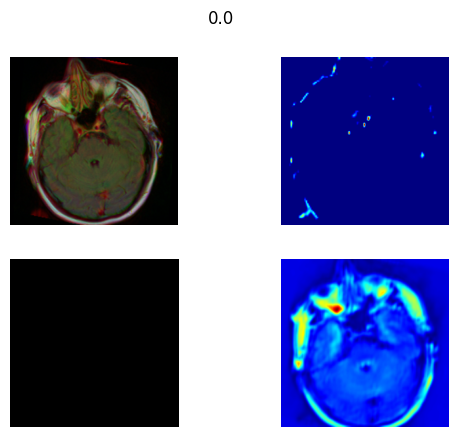

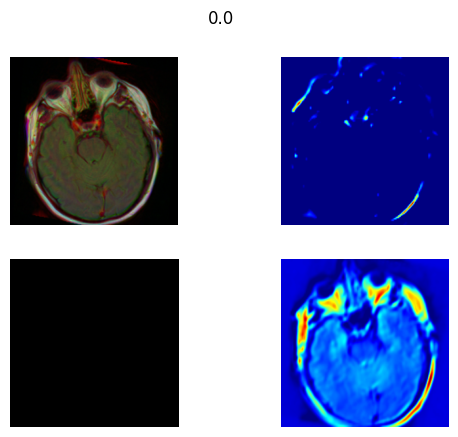

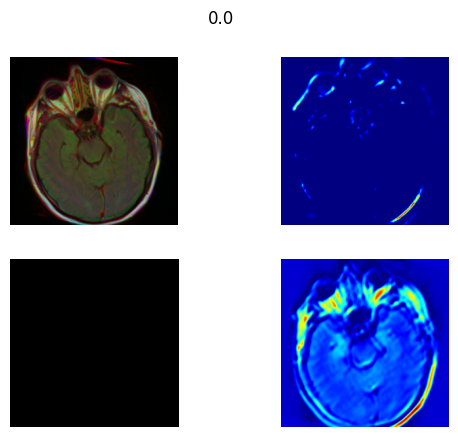

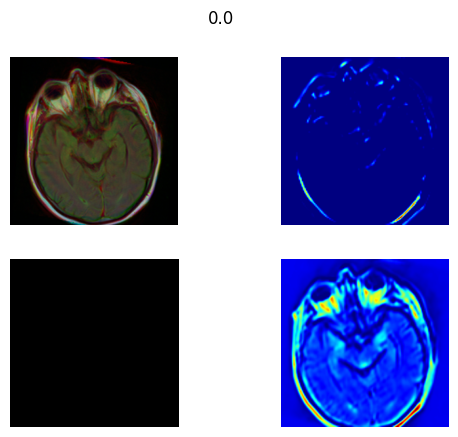

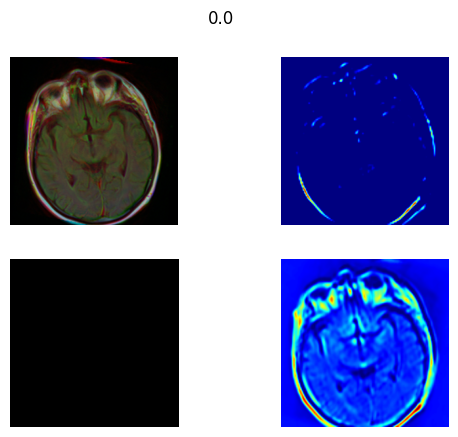

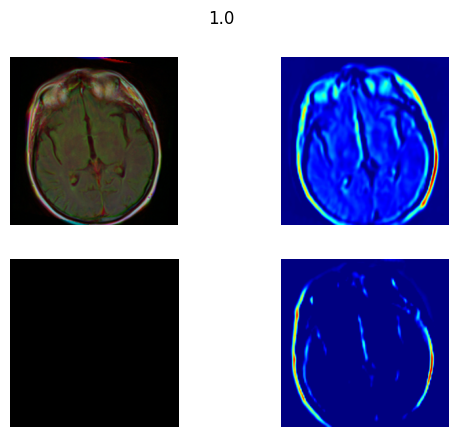

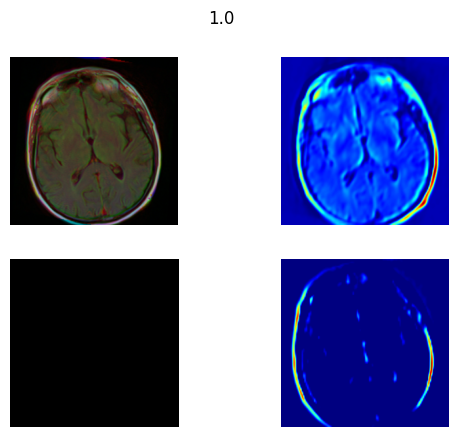

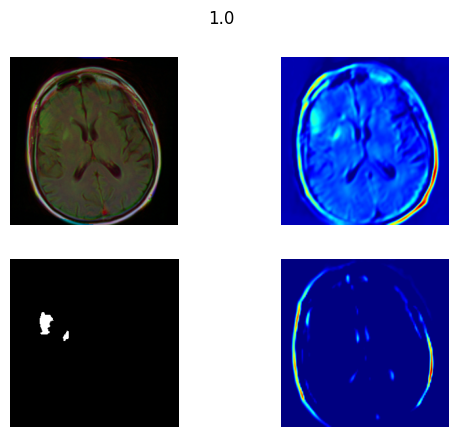

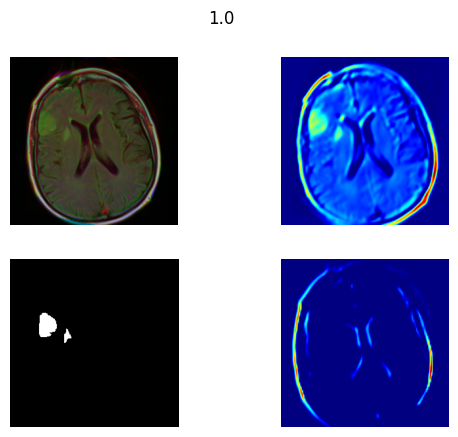

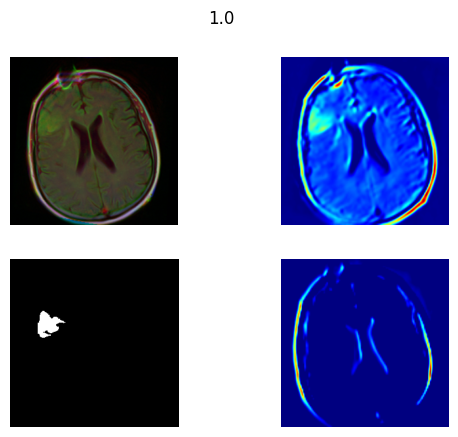

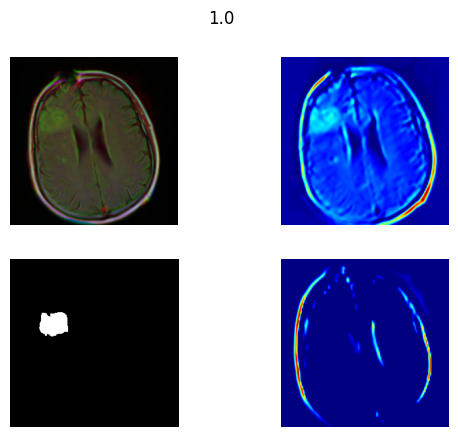

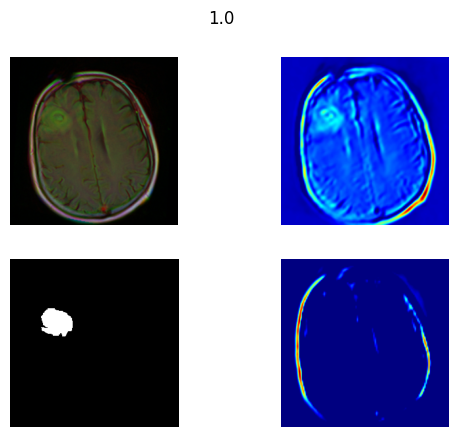

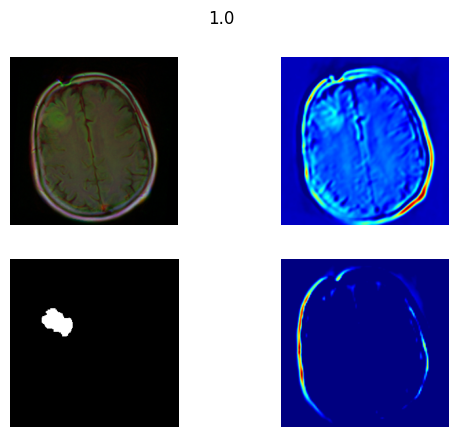

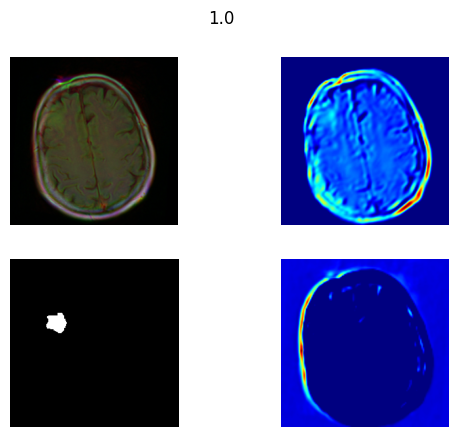

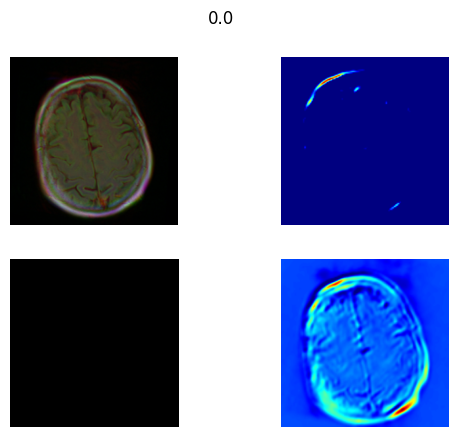

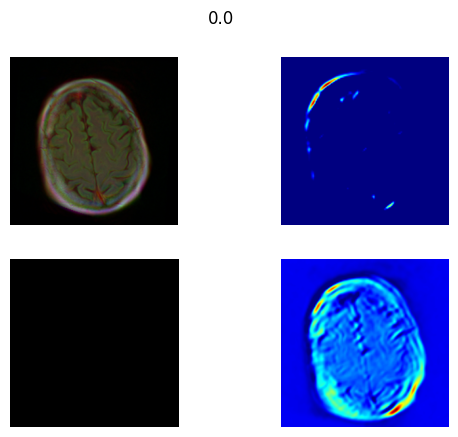

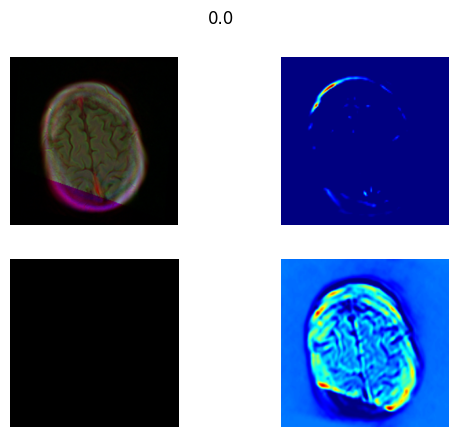

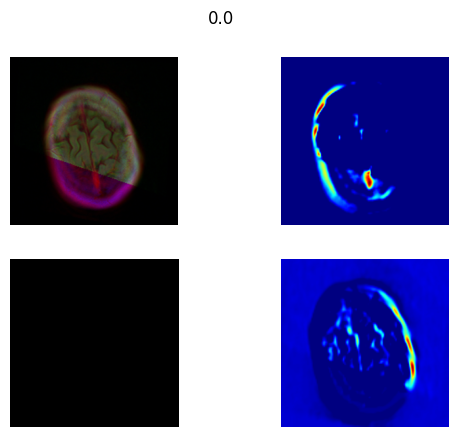

In [9]:
for i in range(1,26):
    visualize_prediction(f'kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_{i}.tif')

0.026585817337036133


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


0.38849735260009766
0.02353501319885254


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


0.37936997413635254
0.02318716049194336


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


0.38793301582336426
0.04426121711730957


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


0.3915579319000244
0.023557662963867188


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


0.3768339157104492
0.023410558700561523


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


0.38716554641723633
0.02315998077392578


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


0.3714170455932617
0.023385286331176758


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


0.3829641342163086
0.02330183982849121


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


0.3880925178527832
0.023905277252197266


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


0.43489885330200195
0.024504423141479492


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


0.46133995056152344
0.02631092071533203


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


0.4547696113586426
0.02449655532836914


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.45133137702941895
0.025122642517089844


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.45742011070251465
0.02559804916381836


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


0.4702029228210449
0.0255429744720459


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


0.44153594970703125
0.025666236877441406


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.4575653076171875
0.025329113006591797


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.44945788383483887
0.02530217170715332


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.45243144035339355


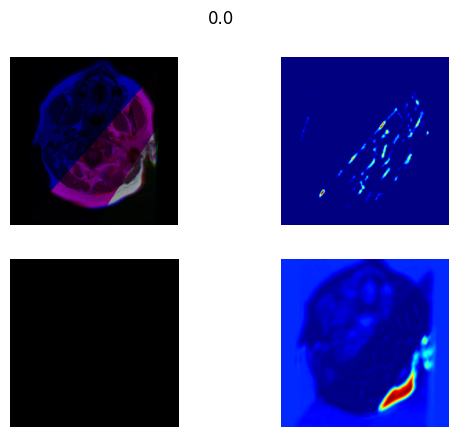

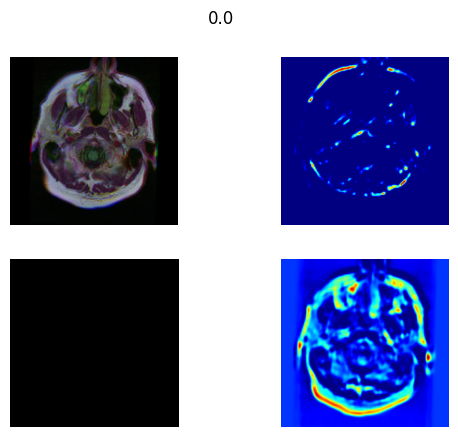

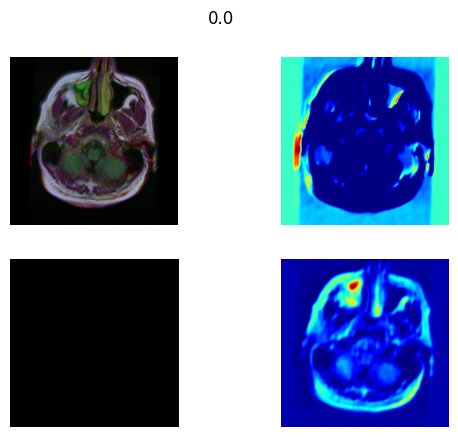

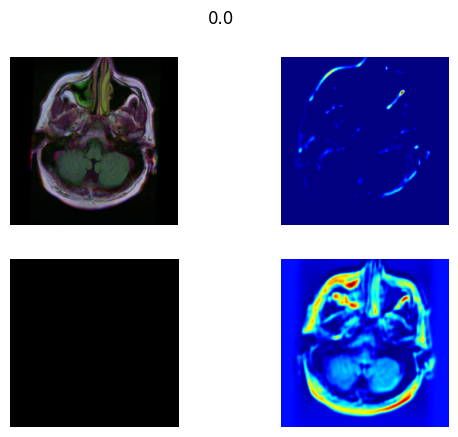

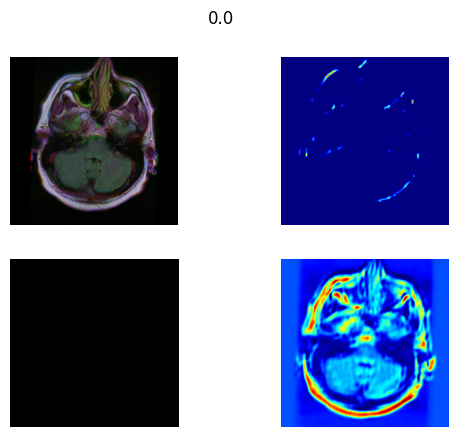

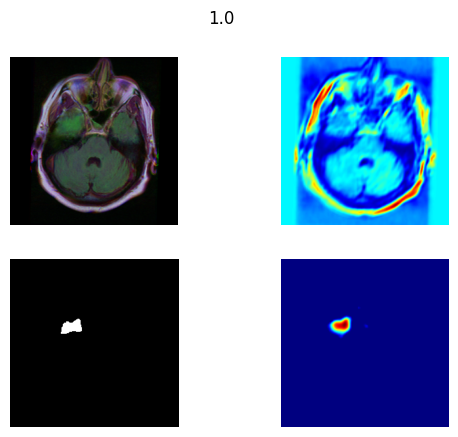

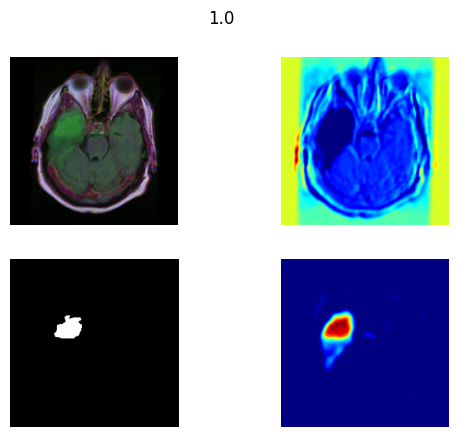

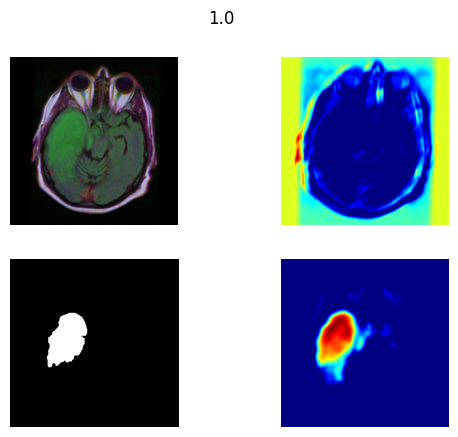

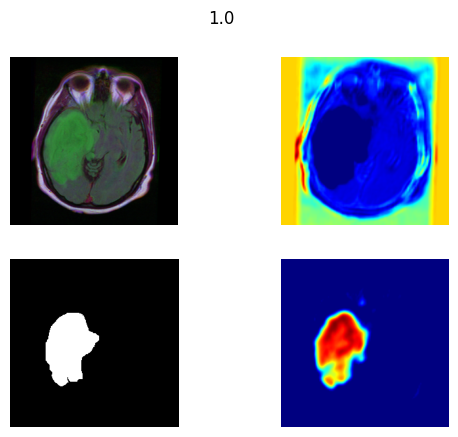

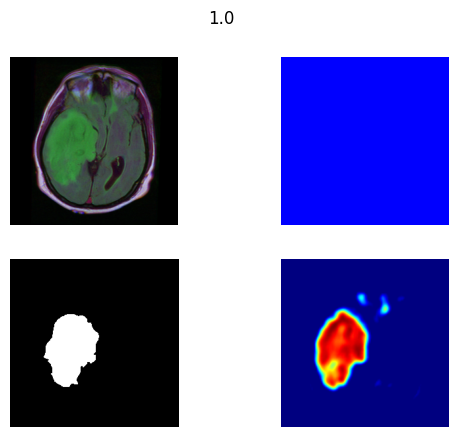

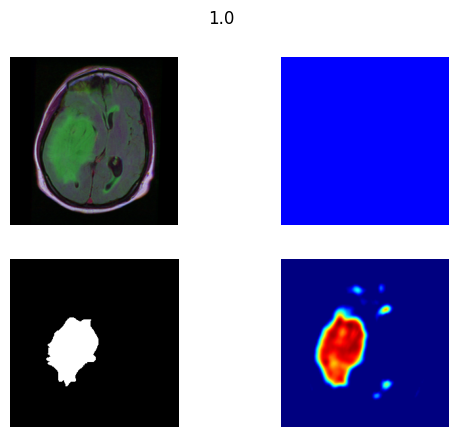

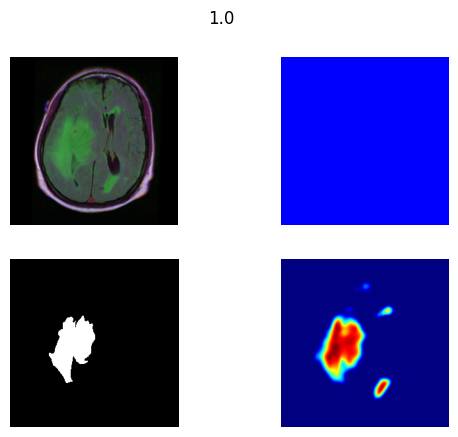

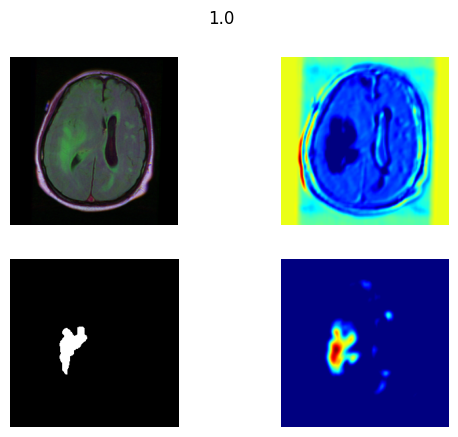

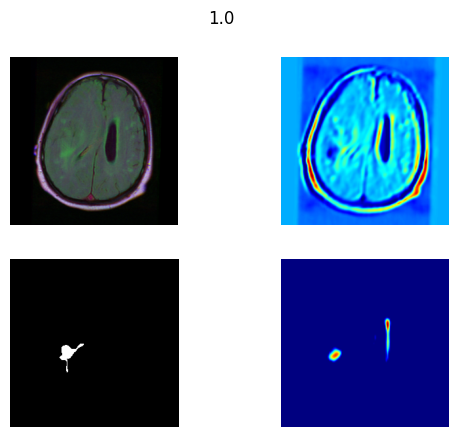

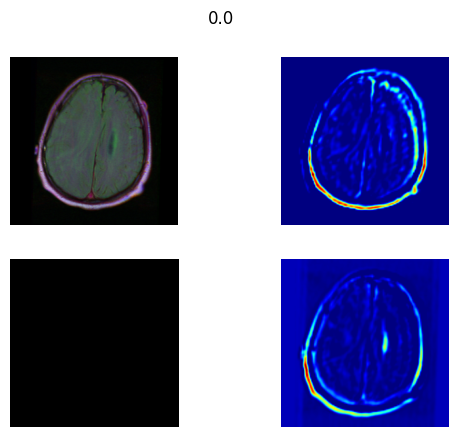

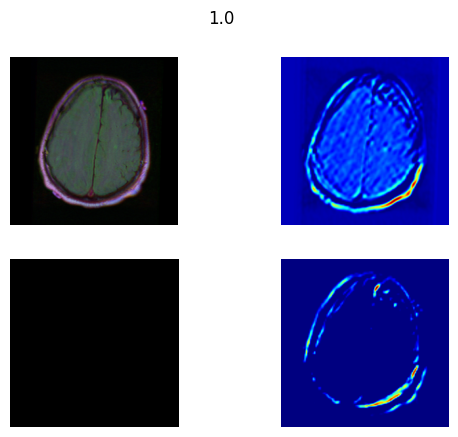

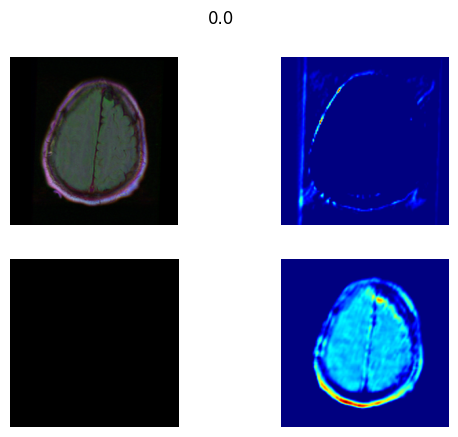

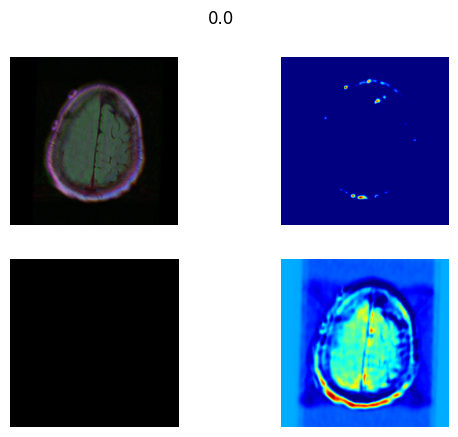

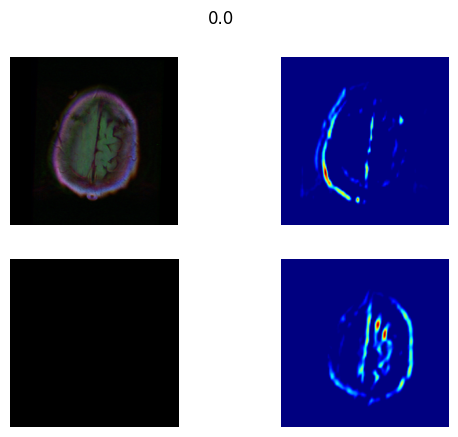

In [10]:

for i in range(1,20):
    visualize_prediction(f'kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_{i}.tif')


Visualize Test

In [11]:
for img in test_df['Image']:
    visualize_prediction(img)

0.02755451202392578


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


0.3869459629058838
0.025597095489501953


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


0.4040844440460205
0.023458242416381836


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


0.38254857063293457
0.02354907989501953


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


0.3865776062011719
0.02236008644104004


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


0.49861693382263184
0.02474212646484375


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.4527409076690674
0.025838851928710938


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.44799256324768066
0.02517867088317871


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.4572174549102783
0.02435922622680664


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.4488658905029297
0.025313854217529297


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.4542858600616455
0.024126529693603516


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


0.4494190216064453
0.02662348747253418


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


0.42447686195373535
0.025518178939819336


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.47089099884033203
0.02530503273010254


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


0.4777538776397705
0.024453163146972656


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.45810389518737793
0.024679183959960938


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.450014591217041
0.02537822723388672


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


0.4481327533721924
0.023493289947509766


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


0.45538854598999023
0.023414134979248047


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


0.443756103515625
0.026588916778564453


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
C:\Users\roee hilel\AppData\Local\Temp\ipykernel_14680\2484463701.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(nrows=2,ncols=2)


0.4543640613555908
0.02435135841369629


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


0.44681715965270996
0.025587797164916992


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


0.44273996353149414
0.025325775146484375


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.449676513671875
0.025293588638305664


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


0.4483013153076172
0.024886608123779297


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.4459843635559082
0.02366161346435547


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.45520806312561035
0.030935287475585938


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


0.42332887649536133
0.025607824325561523


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


0.44669103622436523
0.024265289306640625


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


0.4415895938873291
0.026668071746826172


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


0.4588508605957031
0.025696754455566406


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.4517817497253418
0.02457427978515625


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


0.4570486545562744
0.0233614444732666


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.4496176242828369
0.026013612747192383


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.45142269134521484
0.025430917739868164


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


0.5043385028839111
0.023572683334350586


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.45340681076049805
0.023179054260253906


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.45238447189331055
0.02500605583190918


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


0.4450995922088623
0.025086164474487305


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.45325136184692383
0.025258779525756836


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


0.44878125190734863
0.025659561157226562


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.44632911682128906
0.02547311782836914


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.45546603202819824
0.026228904724121094


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


0.4400594234466553
0.025369882583618164


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.4716756343841553
0.03168749809265137


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


0.39646124839782715
0.02619338035583496


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.448575496673584
0.03434324264526367


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


0.6334118843078613
0.032462358474731445


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


0.515392541885376
0.03008556365966797


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


0.5086371898651123
0.031774044036865234


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


0.5103390216827393
0.03002333641052246


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


0.5617353916168213
0.02730560302734375


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


0.4778268337249756
0.025622129440307617


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.47684264183044434
0.0493314266204834


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


0.6332132816314697
0.03255653381347656


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


0.5220515727996826
0.028560876846313477


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


0.5168344974517822
0.026301860809326172


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


0.5788187980651855
0.026218414306640625


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


0.4825167655944824
0.0255434513092041


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


0.46247363090515137
0.027132272720336914


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


0.4616074562072754
0.025716781616210938


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


0.45532822608947754
0.025950908660888672


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.47083163261413574
0.024892568588256836


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.45006752014160156
0.026361703872680664


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


0.46476149559020996
0.026608943939208984


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.4483466148376465
0.02658247947692871


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.47165536880493164
0.025626659393310547


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.45443105697631836
0.028339385986328125


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


0.41449832916259766
0.02548670768737793


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.4538850784301758
0.0273284912109375


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


0.46447253227233887
0.026055097579956055


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


0.43828678131103516
0.02568650245666504


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


0.4585752487182617
0.026654720306396484


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.4578206539154053
0.02533721923828125


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


0.45586490631103516
0.025075674057006836


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.4581882953643799
0.027080059051513672


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


0.46219730377197266
0.057203054428100586


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


0.47156763076782227
0.04066634178161621


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


0.5180051326751709
0.025615215301513672


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


0.4690871238708496
0.07271885871887207


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


0.5190525054931641
0.031219482421875


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


0.5776734352111816
0.03128314018249512


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


0.5133163928985596
0.02883601188659668


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


0.6638085842132568
0.0358736515045166


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


0.4882028102874756
0.025501489639282227


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.4538578987121582
0.025345563888549805


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


0.43903636932373047
0.026037931442260742


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


0.43987059593200684
0.02578592300415039


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


0.44147658348083496
0.02569437026977539


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


0.43536877632141113
0.023661375045776367


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


0.4540832042694092


This is so cool and a good result too.
One thing to note is that EigenCam method works the best for us, but it takes *100 longer to show, thus in cases when it might not be clear, we can use it

Another intresting note is that it looks that we fail mostly on the edge of the brain (top edge) where it looks blerry and small, with some cleaning of the data we might get better result